In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
import heapq
import datetime
import glob
import random,time

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import *
from tensorflow.keras.regularizers import * 

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
 

import pathlib
import itertools
#import skvideo.io

from operator import itemgetter 

import random


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
main_dir = '/kaggle/input/uw-madison-gi-tract-image-segmentation'
train_folder = os.path.join(main_dir, 'train')
test_folder = os.path.join(main_dir, 'test')

In [3]:
train_df = pd.read_csv(os.path.join(main_dir, 'train.csv'))
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
print(len(train_df))
print('class null values: {:.2f}%'.format(train_df['class'].isna().sum() / len(train_df) * 100))
print('segmentation null values: {:.2f}%'.format(train_df['segmentation'].isna().sum() / len(train_df) * 100))

115488
class null values: 0.00%
segmentation null values: 70.64%


In [5]:
classes = train_df.loc[:, 'class'].unique().tolist()
classes

['large_bowel', 'small_bowel', 'stomach']

In [6]:
for cl in classes:
    print('{}: {}'.format(cl, len(train_df[train_df['class'] == cl])))

large_bowel: 38496
small_bowel: 38496
stomach: 38496


In [7]:
# group train dataset by id, add 3 new columns: 'large_bowel', 'small_bowel', 'stomach'
#--------------------------------------------------------------------------------------
train_df_grouped = train_df.copy()
train_df_grouped.set_index('id', inplace = True)

seg_list = []
for cl in classes:
    seg = train_df_grouped[train_df_grouped['class'] == cl]['segmentation']
    seg.name = cl
    seg_list.append(seg)
    
train_df_grouped = pd.concat(seg_list, axis=1).reset_index()
train_df_grouped.fillna('', inplace = True)
train_df_grouped.head()

,id,large_bowel,small_bowel,stomach
0,case123_day20_slice_0001,,,
1,case123_day20_slice_0002,,,
2,case123_day20_slice_0003,,,
3,case123_day20_slice_0004,,,
4,case123_day20_slice_0005,,,


In [8]:
def get_case_day_slice(x):
    
    #--------------------------------------------------------------------------------------
    # function that parses a string (full_path or image_id)
    # and returns case, day, slice_ 
    #--------------------------------------------------------------------------------------
    
    case = re.search('case[0-9]+', x).group()[len('case'):]
    day = re.search('day[0-9]+', x).group()[len('day'):]
    slice_ = re.search('slice_[0-9]+', x).group()[len('slice_'):]
    return case, day, slice_

In [9]:
from glob import glob
import re

case_day_slice = ['case', 'day', 'slice_']

def process_df(df, path):
    
    #--------------------------------------------------------------------------------------
    # add new columns:
    # ['case', 'day', 'slice_']
    # and
    # 'full_path'
    #--------------------------------------------------------------------------------------
    
    df = df.copy()
    df.loc[:, case_day_slice] = df.id.apply(get_case_day_slice).to_list()
    
    # get list of all images 
    all_images = glob(os.path.join(path, "**", "*.png"), recursive = True)
    img_df = pd.DataFrame(all_images, columns = ['full_path'])
    img_df.loc[:, case_day_slice] = img_df.full_path.apply(get_case_day_slice).to_list()
    
    return df.merge(img_df, on = case_day_slice, how = 'left')


In [10]:
train_df_grouped = process_df(train_df_grouped, train_folder)
train_df_grouped.head()

,id,large_bowel,small_bowel,stomach,case,day,slice_,full_path
0,case123_day20_slice_0001,,,,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...
1,case123_day20_slice_0002,,,,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...
2,case123_day20_slice_0003,,,,123,20,0003,/kaggle/input/uw-madison-gi-tract-image-segmen...
3,case123_day20_slice_0004,,,,123,20,0004,/kaggle/input/uw-madison-gi-tract-image-segmen...
4,case123_day20_slice_0005,,,,123,20,0005,/kaggle/input/uw-madison-gi-tract-image-segmen...


In [11]:
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 7) | (train_df_grouped['day'] != 0)].reset_index(drop = True)
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 81) | (train_df_grouped['day'] != 30)].reset_index(drop = True)

In [12]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [13]:
# get an example of image having non-null 'large_bowel' mask
example_row = train_df_grouped[train_df_grouped['large_bowel'] != ''].iloc[0, :]
example_row

id                                      case123_day20_slice_0075
large_bowel    23058 4 23323 6 23588 8 23854 9 24119 10 24385...
small_bowel                                                     
stomach        12388 11 12652 14 12916 18 13180 22 13445 24 1...
case                                                         123
day                                                           20
slice_                                                      0075
full_path      /kaggle/input/uw-madison-gi-tract-image-segmen...
Name: 74, dtype: object

In [14]:
img_path = example_row.full_path
img_path

'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0075_266_266_1.50_1.50.png'

In [15]:
import matplotlib.pyplot as plt

def print_img_info(img):
    img_arr = np.asarray(img)
    print(img_arr.shape)
    print(img_arr[100])
    plt.imshow(img, cmap='gray')

(266, 266)
[0.         0.         0.         0.         0.         0.
 0.00666819 0.00637827 0.00579843 0.00724804 0.00782788 0.00492866
 0.00492866 0.00608835 0.00521859 0.02348363 0.05740444 0.07016098
 0.07364004 0.04696727 0.02319371 0.01565576 0.01188678 0.0162356
 0.02580301 0.03479057 0.05073625 0.05624475 0.04841688 0.03044175
 0.01275654 0.03102159 0.03739986 0.03392081 0.02899214 0.03421073
 0.03826963 0.03102159 0.03768978 0.04000916 0.03421073 0.03392081
 0.03392081 0.0365301  0.04029908 0.03768978 0.03682002 0.03566033
 0.03595025 0.03624018 0.03566033 0.03508049 0.03566033 0.03421073
 0.03044175 0.03073167 0.03479057 0.04261845 0.04116884 0.03566033
 0.03450065 0.03913939 0.04493782 0.040589   0.03537041 0.03595025
 0.03797971 0.04000916 0.04000916 0.04116884 0.03797971 0.04000916
 0.03739986 0.03942931 0.04377813 0.03826963 0.03508049 0.03855955
 0.04290837 0.03971924 0.04348821 0.04319829 0.03913939 0.03884947
 0.03739986 0.03305104 0.03739986 0.04522774 0.040589   0.03

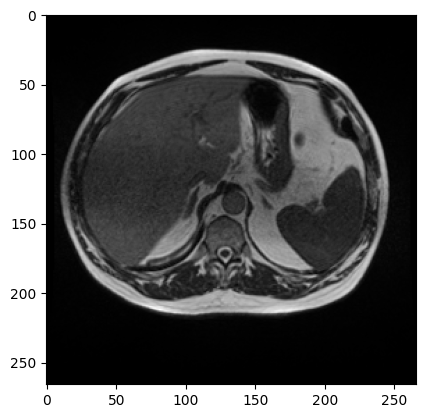

In [16]:
import matplotlib.image as mpimg
print_img_info(mpimg.imread(img_path, format = 'png'))

(266, 266)
[   0.    0.    0.    0.    0.    0.  437.  418.  380.  475.  513.  323.
  323.  399.  342. 1539. 3762. 4598. 4826. 3078. 1520. 1026.  779. 1064.
 1691. 2280. 3325. 3686. 3173. 1995.  836. 2033. 2451. 2223. 1900. 2242.
 2508. 2033. 2470. 2622. 2242. 2223. 2223. 2394. 2641. 2470. 2413. 2337.
 2356. 2375. 2337. 2299. 2337. 2242. 1995. 2014. 2280. 2793. 2698. 2337.
 2261. 2565. 2945. 2660. 2318. 2356. 2489. 2622. 2622. 2698. 2489. 2622.
 2451. 2584. 2869. 2508. 2299. 2527. 2812. 2603. 2850. 2831. 2565. 2546.
 2451. 2166. 2451. 2964. 2660. 2413. 2755. 2717. 2736. 2527. 2413. 2584.
 2527. 2622. 2622. 2603. 2603. 2489. 2508. 2660. 2679. 2280. 2394. 2318.
 2451. 2679. 2508. 2622. 2394. 2356. 2261. 1976. 2033. 2565. 2641. 2603.
 2565. 2546. 2660. 2622. 2717. 2470. 2204. 2660. 2660. 2736. 3078. 3667.
 4294. 4256. 4807. 5263. 5434. 5453. 4807. 3876. 3800. 3648. 4218. 5187.
 5567. 6175. 5681. 5263. 4959. 3534. 1881. 1577. 1843. 2261. 3192. 4541.
 5738. 5149. 3097. 1482. 1539. 2850. 383

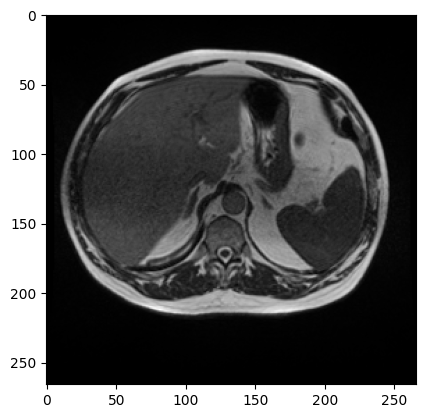

In [17]:
img = tf.keras.preprocessing.image.load_img(img_path, color_mode = "grayscale")
img = tf.keras.preprocessing.image.img_to_array(img)
print_img_info(img[:, :, 0])

In [18]:
mask_seq = example_row.large_bowel

(266, 266, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


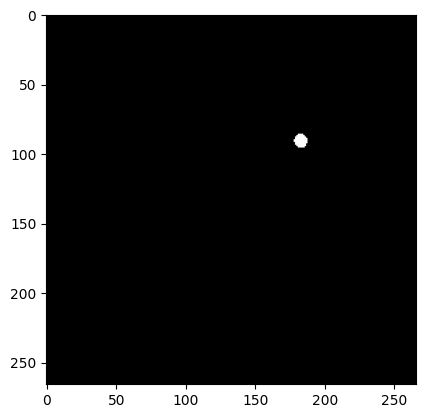

In [19]:

mask = rle_decode(mask_seq, img.shape)
print(mask.shape)
print(mask[90, :, 0])
plt.imshow(mask, cmap= 'gray')

In [20]:
import matplotlib.colors as mcolors

# Define a custom color map with 4 colors (one for each class)
colors = ['black', 'red', 'green', 'blue']
cmap = mcolors.ListedColormap(colors)

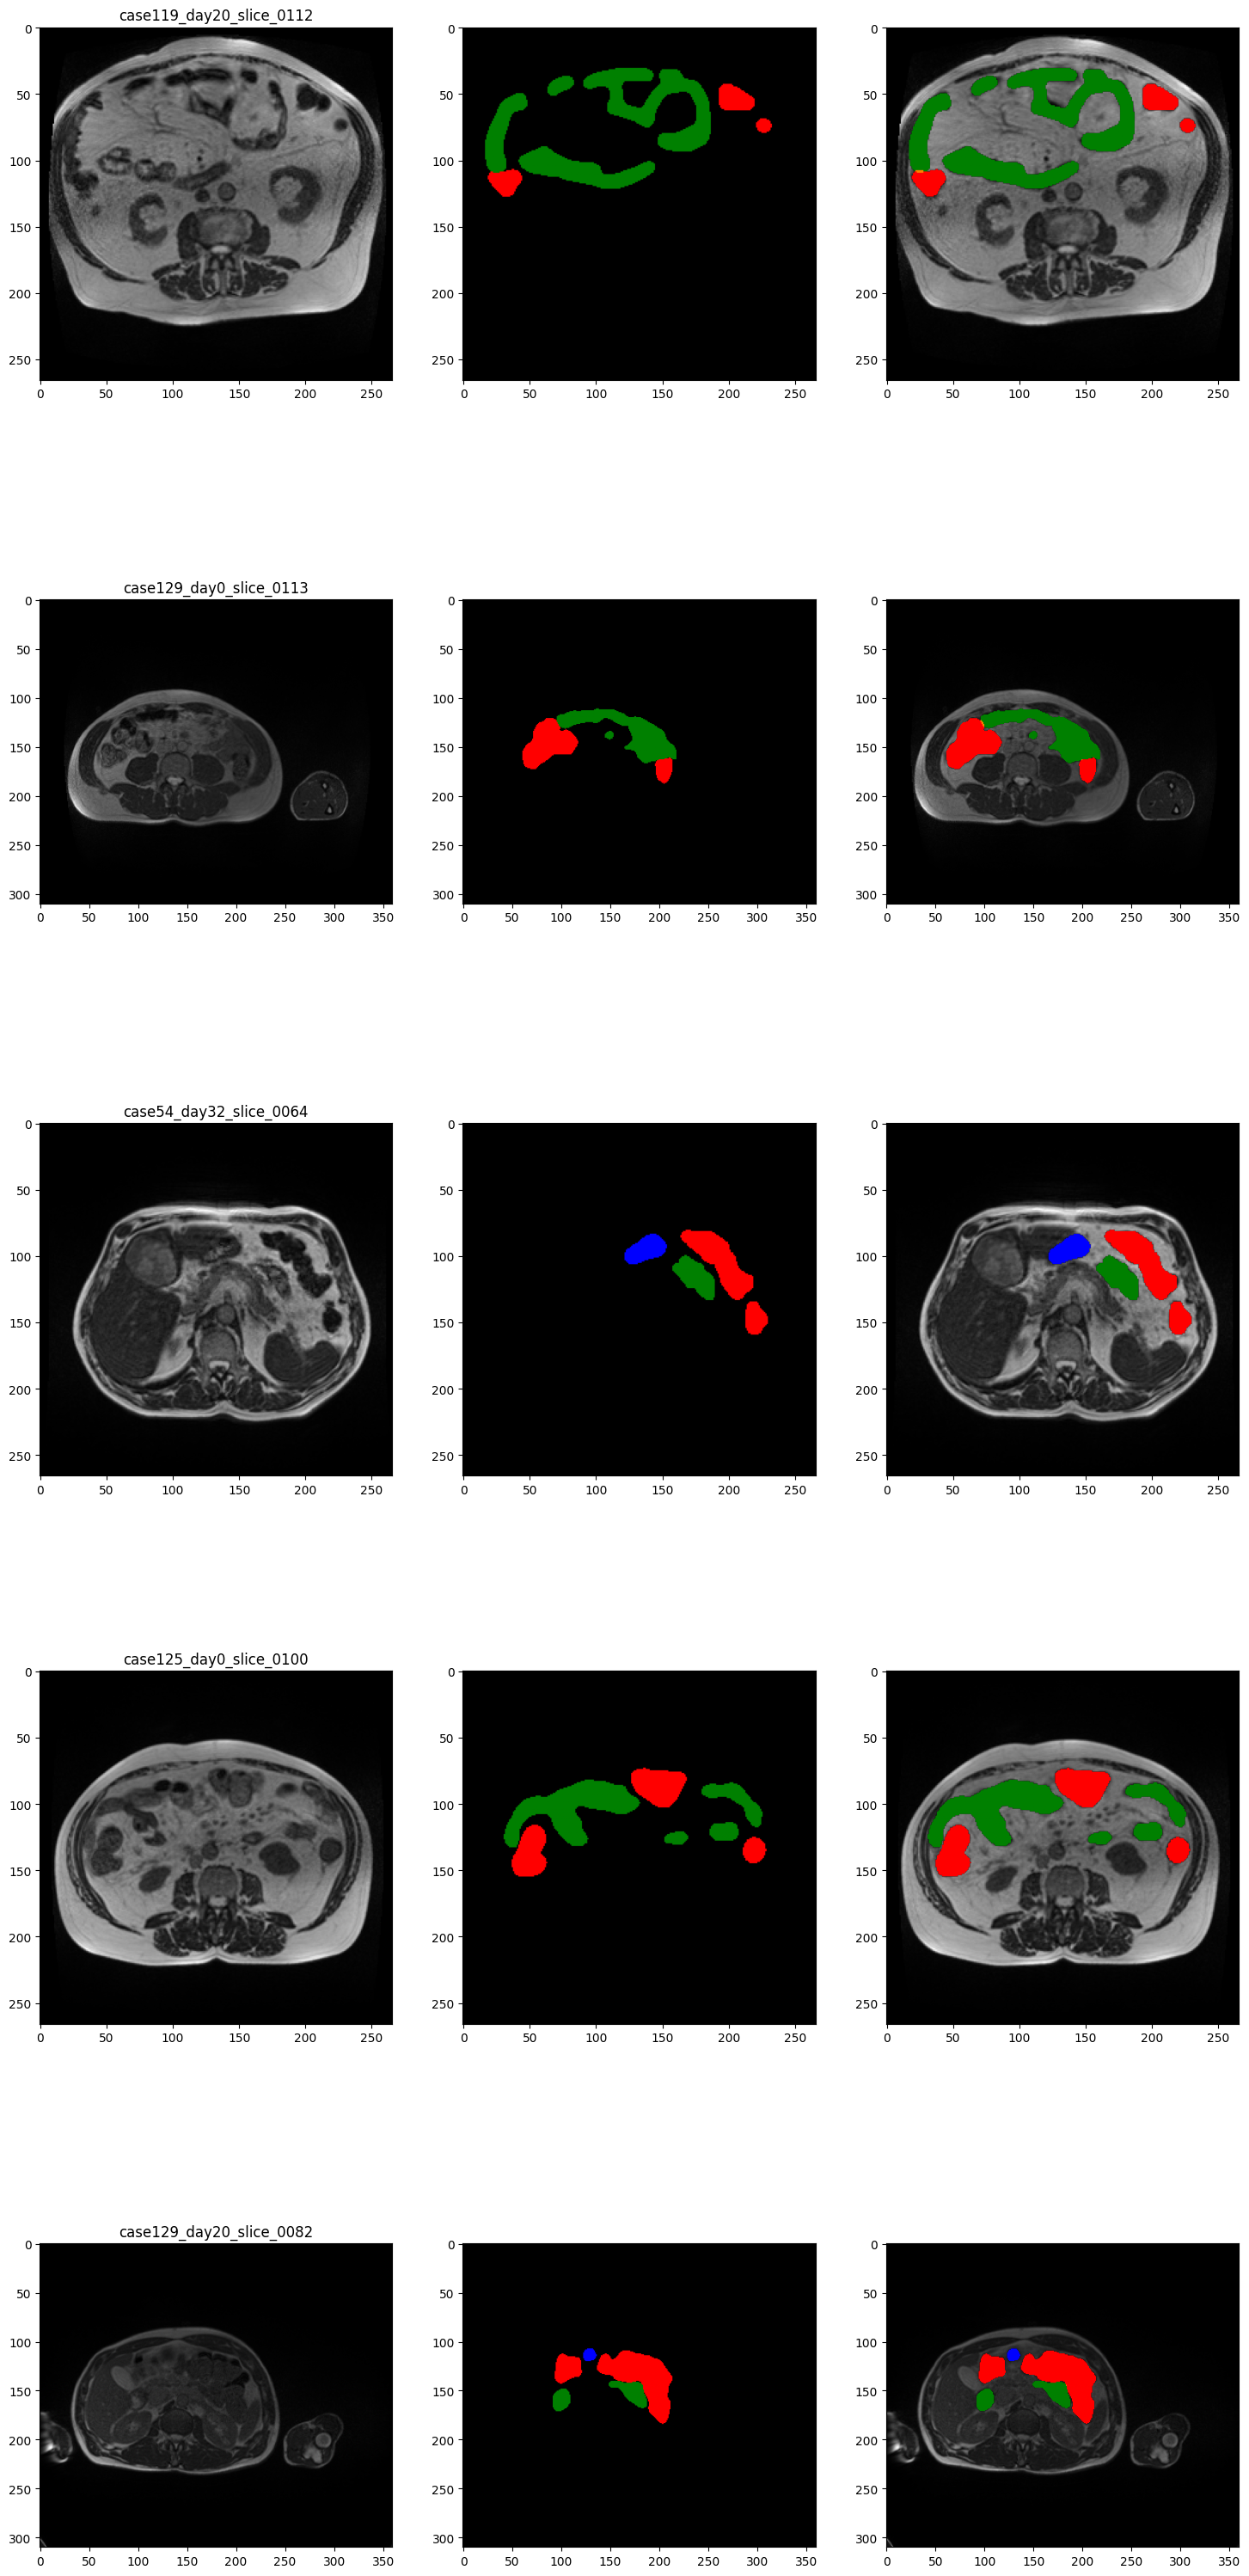

In [21]:
num = 5
segmentation_df_example = train_df_grouped[train_df_grouped.large_bowel != ''].sample(num)

fig, ax = plt.subplots(num, 3, figsize=(18, 8*num))
for i in range(num):
    record = segmentation_df_example.iloc[i, :]

    img = mpimg.imread(record.full_path, format='png')
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 0].set_title(record.id)

    mask = np.zeros(img.shape[:2], dtype=np.int32)
    for j, cl in enumerate(classes):
        current_mask = rle_decode(record[cl], img.shape[:2])
        mask[current_mask > 0] = j + 1
    
    alpha = 0.5
    mask_colored = cmap(mask)
    ax[i, 1].imshow(mask_colored)

    alpha = 0.5
    masked_img = np.zeros((*img.shape, 4))
    for j, cl in enumerate(classes):
        current_mask = rle_decode(record[cl], img.shape[:2])
        masked_img += current_mask[..., np.newaxis] * cmap(j + 1)

    ax[i, 2].imshow(img, cmap='gray')
    ax[i, 2].imshow(masked_img, cmap=cmap)

In [22]:
from enum import Enum, auto

class GeneratorMode(Enum):
    TRAIN = auto()
    TEST = auto()

In [23]:
img_size = 160

class ImageDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                 df,
                 batch_size,
                 mode = GeneratorMode.TRAIN):

        self.df = df
        self.batch_size = batch_size
        self.image_size = img_size
        self.mode = mode
        
        self.len = len(df)
        
    def __getitem__(self, index):
        
        start, end = index * self.batch_size, (index + 1) * self.batch_size
        
        images = np.zeros((self.batch_size, self.image_size, self.image_size, 1))
        masks = np.zeros((self.batch_size, self.image_size, self.image_size, len(classes)))
        for i , pos in enumerate(range(start, end)):
            row = self.df.iloc[pos, :]
            
            #image
            image = tf.keras.preprocessing.image.load_img(row['full_path'], color_mode = "grayscale")
            image = tf.keras.preprocessing.image.img_to_array(image)
            image_shape = image.shape
            
            image = tf.image.resize(image, (self.image_size, self.image_size), method = 'nearest').numpy()
            image = image.reshape((self.image_size, self.image_size))
            images[i, :, :, 0] = image / np.max(image)
            
            # masks (only train/val mode)
            if self.mode == GeneratorMode.TRAIN:
                for j, cl in enumerate(classes):
                    feat = row[cl]
                    mask = rle_decode(feat, image_shape)
                    mask = tf.image.resize(mask, (self.image_size, self.image_size), method = 'nearest').numpy()
                    mask = mask.reshape((self.image_size, self.image_size))
                    masks[i, :, :, j] = mask
              
        return (images, masks) if self.mode == GeneratorMode.TRAIN else images
                
    
    def __len__(self):
        return self.len // self.batch_size

In [24]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train_df_grouped, test_size = 0.1, shuffle = True, random_state = 42)

In [25]:
train_data_gen = ImageDataGen(train_set, 64)
val_data_gen = ImageDataGen(val_set, 64)

In [26]:
from tensorflow.keras import layers

In [27]:
filters=256
depth=4
kernel_size=5
patch_size=2

In [28]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_blocko(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def downsample_block(x, n_filters):
    f = patch_mix(x, n_filters, patch_size,depth, kernel_size) 
    p = layers.Dropout(0.3)(f)
    f =   UpSampling2D(size=(2, 2)) (p)
    return f, p




def preproc(x):
    x1 = Conv2D(1, 3, padding = "same", activation = "gelu")(x)
    x2 = Conv2D(1, 5, padding = "same", activation = "gelu")(x)
    x3 = Conv2D(1, 7, padding = "same", activation = "gelu")(x)
    #x4 = Conv2D(1, 5, padding = "same", activation = "gelu")(x)
    s1 = Subtract()([x2,x1])
    s2 = Subtract()([x3,x2])
    
    conc = Concatenate()([x,s1,s2])
    
    
    
    return conc
 

In [29]:
import tensorflow as tf

kld = tf.keras.losses.KLDivergence()

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


In [30]:
import tensorflow as tf

def tversky_loss(alpha=0.5, beta=0.5, smooth=1e-6):
    def loss(y_true, y_pred):
        # Flatten the predicted and true masks
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)

        # Calculate the true positives, false positives, and false negatives
        true_positives = tf.keras.backend.sum(y_true_f * y_pred_f)
        false_positives = tf.keras.backend.sum((1 - y_true_f) * y_pred_f)
        false_negatives = tf.keras.backend.sum(y_true_f * (1 - y_pred_f))

        # Calculate the Tversky coefficient
        tversky_coef = (true_positives + smooth) / (true_positives + alpha * false_positives + beta * false_negatives + smooth)

        # Calculate the Tversky loss as 1 - Tversky coefficient
        tversky_loss = 1.0 - tversky_coef

        return tversky_loss
    
    return loss


In [31]:
def activation_block(x):
    x = Activation("gelu")(x)
    return LayerNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = Conv2D(filters, kernel_size=patch_size,padding='same', strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x



def patch_mix(inputs, filters, patch_size,depth, kernel_size):
    x = conv_stem(inputs, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
         x = conv_mixer_block(x, filters, kernel_size)
    return x

In [32]:
def vector_block(xyz,cmf, red):
    # red means reduction 
    # cmf means filters, denotes vector size
    x = xyz
    opt1 = conv_stem(x,cmf,red)
    opt2 = conv_stem(x,cmf,red)
    opt3 = conv_stem(x,cmf,red)
    opt4 = conv_stem(x,cmf,red)


    o1 = tf.reduce_mean(opt1,[2,1])
    o2 = tf.reduce_mean(opt2,[2,1])
    o3 = tf.reduce_mean(opt3,[2,1])
    o4 = tf.reduce_mean(opt4,[2,1])
    o5 = concatenate([o1,o2,o3,o4],-1)
    return o5

def mlp_feature(vect,cmf):
    
 
    oo = Flatten()(vect) 
    o6 =  Dense(cmf*2, activation='gelu')(oo)
    o6 =  Dropout(0.2)(o6)
    o6 =  Dense(cmf*4, activation='gelu')(o6)

    o6= Reshape((1, cmf*4))(o6)
    o7 =  K.permute_dimensions(o6, (0,2,1))
    
    o8 = multiply([o6,o7])
    o8 =tf.expand_dims(o8,-1)
    o8 =   MaxPool2D(4)(o8 )
    
    
    return o8


def regu(xyz, filt):
    x = Conv2D(filt,(3,3), activation='gelu', padding="same")(xyz) 
    x =   MaxPool2D(2)(x)
    return x


def frz_block(xyz):
    [a1,a2,a3,a4] =xyz.get_shape()
    cmf = a2
    o5 = vector_block(xyz,cmf, 5)
    o7 = mlp_feature(o5,cmf) 

    o7 = concatenate([o7,xyz,o7],-1)
    return o7


def frz_blocke(xyz):
    [a1,a2,a3,a4] =xyz.get_shape()
    cmf = a2
    o5 = vector_block(xyz,cmf, 5)
    o7 = mlp_feature(o5,cmf) 
 
    return o7

def up_frz(x1,x2, n_filters):
    x1 = Conv2DTranspose(n_filters*4, 3, 2, activation='gelu', padding="same")(x1)
    x2 = Conv2D(n_filters*2, 3, activation='gelu', padding="same")(x2)
    x =  concatenate([x1, x2])
    x =  Dropout(0.3)(x)
    return x

In [33]:
def cab(input_tensor,channels):
    channels = list(input_tensor.shape)[-1]
    average_pooling =  GlobalAveragePooling2D()(input_tensor)
    
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    
    feature_activations =  Conv2D(filters=channels // 8, kernel_size=(1, 1), activation="relu")(feature_descriptor)
    
    feature_activations = Conv2D(filters=channels, kernel_size=(1, 1), activation="sigmoid")(feature_activations)
    return input_tensor * feature_activations



def sab(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map



def daub(input_tensor,channels):
    channels = list(input_tensor.shape)[-1]
    feature_map = Conv2D(channels, kernel_size=(3, 3), padding="same", activation="relu")(input_tensor)
    feature_map = Conv2D(channels, kernel_size=(3, 3), padding="same")(feature_map)
    channel_attention = cab(feature_map, channels)
    spatial_attention = sab(feature_map)
    concatenation = Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return Add()([input_tensor, concatenation])




def vector_blocke(xyz,cmf):
    # red means reduction 
    # cmf means filters, denotes vector size
    x = xyz
    opt1 = conv_stem(x,cmf,1)
    opt2 = conv_stem(x,cmf,3)
    opt3 = conv_stem(x,cmf,5)
    opt4 = conv_stem(x,cmf,7)


    o1 = tf.reduce_mean(opt1,[2,1])
    o2 = tf.reduce_mean(opt2,[2,1])
    o3 = tf.reduce_mean(opt3,[2,1])
    o4 = tf.reduce_mean(opt4,[2,1])
    o5 = concatenate([o1,o2,o3,o4],-1)
    o5 = Dense(cmf, activation='gelu')(o5)
    o5 = tf.reshape(o5, shape=(-1, 1, 1, cmf))
    fe =  Conv2D(cmf // 8, kernel_size=(1, 1), padding='same',  activation="relu")(o5)
    
    fa = Conv2D(cmf, kernel_size=(1, 1), padding='same',activation="sigmoid")(fe)
    
    
    return fa*xyz

In [34]:
inputs = layers.Input(shape=(img_size, img_size, 1))

g_filter = 32
u_filter = 8

o1 = frz_block( regu((inputs),g_filter)) #80

o2 =  frz_block(regu(o1,g_filter*2))  #40

o3 =  frz_block(regu(o2,g_filter*4))  #20

o4 =  frz_block(regu(o3,g_filter*8))  #10

o5 =  frz_block(regu(o4,g_filter*16))  #5
 
## -------------------------------------- ##    
    
    
u1 =  up_frz(o5,o4,u_filter*16)  # 10 

cu1 =  concatenate([u1, o4]) # 10 


u2 =  up_frz(cu1,o3,u_filter*8) # 20 

cu2 =  concatenate([u2, o3]) # 20 

u3 =  up_frz(cu2,o2,u_filter*4) # 40 


cu3 =  concatenate([u3, o2])  # 40 

u4 =  up_frz(cu3,o1,u_filter*2) # 40 

cu4 =  concatenate([u4, o1])  # 40 


ex_u = UpSampling2D(2)(o1)

u5 =  up_frz(cu4,ex_u,u_filter) # 40 

## -------------------------------------- ##  


seg_map = Conv2D(3 , 3, activation='sigmoid', padding="same")(u5) 


gram_matrix = Model(inputs, seg_map)

gram_matrix.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 80, 80, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [35]:

gram_matrix.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                    loss=tversky_loss(alpha=0.5, beta=0.5), metrics = [dice_coef, iou_coef])

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2, verbose = 1)
checkpoint_filepath = 'gram_matrix_model.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, save_best_only=True, monitor='val_loss', mode='min')


In [37]:
EPOCHS = 56
history = gram_matrix.fit(train_data_gen,
                         validation_data = val_data_gen, 
                         epochs = EPOCHS, callbacks = [  reduce_lr, checkpoint])

Epoch 1/56


2023-05-08 06:39:54.770228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


541/541 [==============================] - 862s 2s/step - loss: 0.9154 - dice_coef: 0.0846 - iou_coef: 0.1040 - val_loss: 0.8438 - val_dice_coef: 0.1562 - val_iou_coef: 0.3971 - lr: 1.0000e-04
Epoch 2/56
541/541 [==============================] - 664s 1s/step - loss: 0.7319 - dice_coef: 0.2682 - iou_coef: 0.4191 - val_loss: 0.6539 - val_dice_coef: 0.3461 - val_iou_coef: 0.4291 - lr: 1.0000e-04
Epoch 3/56
541/541 [==============================] - 643s 1s/step - loss: 0.5622 - dice_coef: 0.4378 - iou_coef: 0.5193 - val_loss: 0.5278 - val_dice_coef: 0.4722 - val_iou_coef: 0.5169 - lr: 1.0000e-04
Epoch 4/56
541/541 [==============================] - 652s 1s/step - loss: 0.4503 - dice_coef: 0.5497 - iou_coef: 0.6167 - val_loss: 0.4204 - val_dice_coef: 0.5796 - val_iou_coef: 0.6348 - lr: 1.0000e-04
Epoch 5/56
541/541 [==============================] - 654s 1s/step - loss: 0.3738 - dice_coef: 0.6262 - iou_coef: 0.6795 - val_loss: 0.3434 - val_dice_coef: 0.6566 - val_iou_coef: 0.7108 - lr: 1.

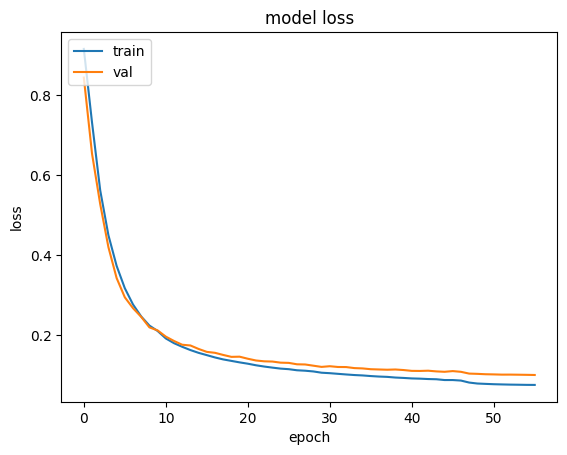

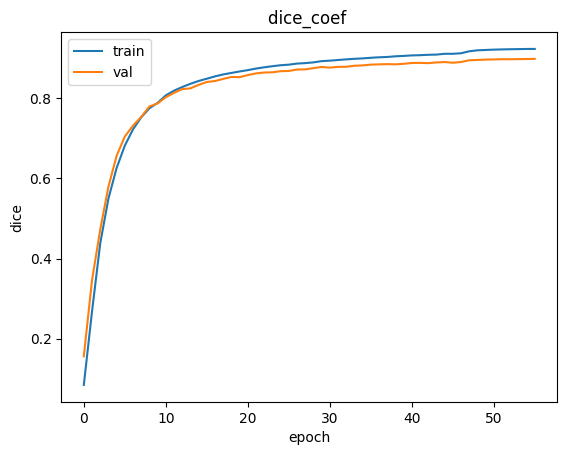

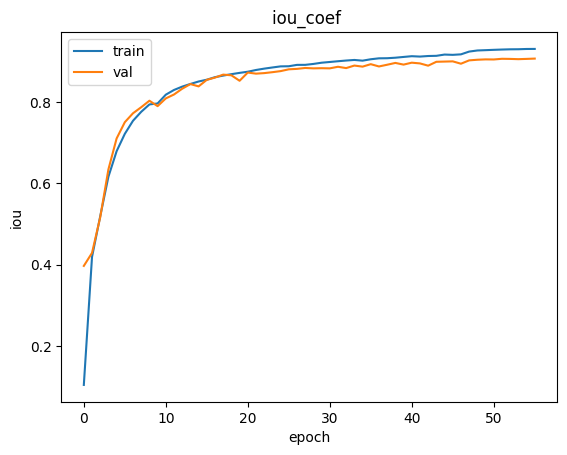

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for dice
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice_coef ')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for IOU
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('iou_coef ')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
valm = []
valb = []


k1,k2 = next(iter(val_data_gen))
valm.append(k1)
valb.append(k2)

In [40]:
valm = np.array(valm)
valb = np.array(valb)
s1,s2,s3,s4,s5 = valm.shape

valrm = np.reshape(valm,[s1*s2,s3,s4,s5])
valrb = np.reshape(valb,[s1*s2,s3,s4,s5*3])

In [41]:
classes = ['large_bowel', 'small_bowel', 'stomach']

def sub3(f1,f2,f3):

    fig, ax = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(131)
    plt.imshow(f1)
    plt.title("input image")
    plt.subplot(132)
    plt.imshow(f2)
    plt.title("Predicted")
    plt.subplot(133)
    plt.imshow(f3)
    plt.title("Groun Truth")
    plt.show()

In [42]:
gram_matrix = gram_matrix.predict(valrm, 16)

4/4 [==============================] - 2s 25ms/step


In [43]:
max_val_list = ([ np.max(wv_num)  for wv_num in   ( valrb)   ])

indices = [i for i, x in enumerate(max_val_list) if x == 1]

len(indices)

27

In [44]:
def sub4(f1, f2, f3, f4):
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(f1, cmap='gray')
    ax[0].set_title('Input image')
    ax[1].imshow(f2)
    ax[1].set_title('Predicted')
    ax[2].imshow(f3)
    ax[2].set_title('Ground truth')
    ax[3].imshow(f4)
    ax[3].set_title('Predicted masked image')
    plt.show()

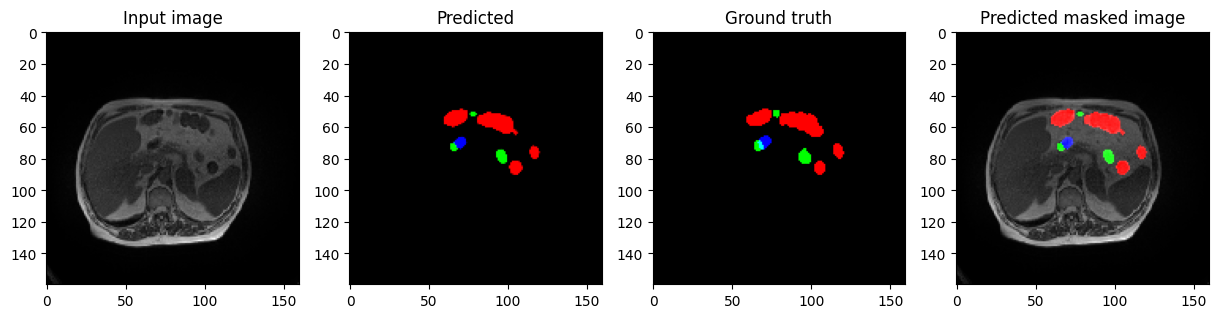

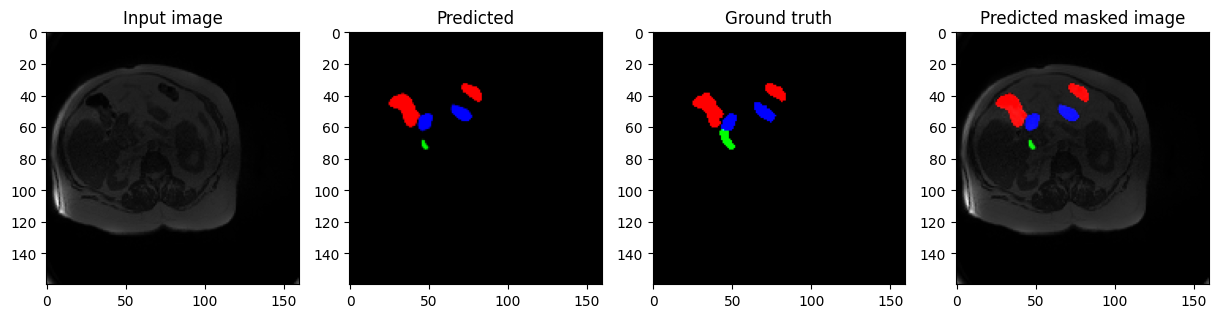

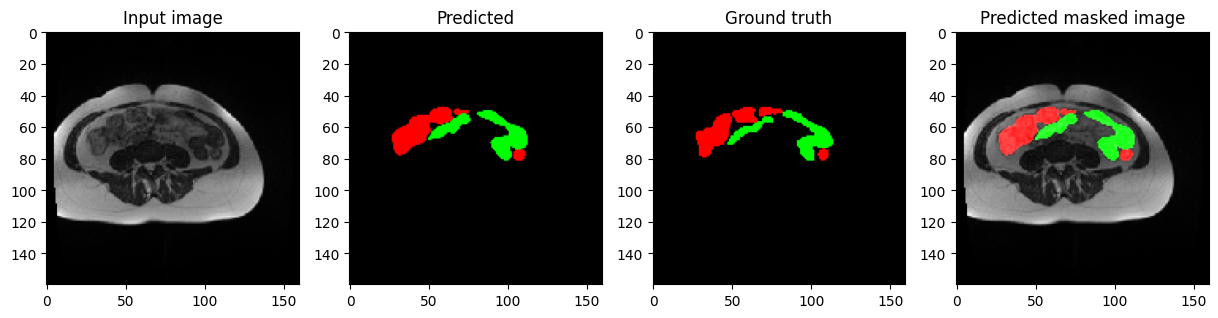

In [45]:
fid = 3

sub4(valrm[indices[fid]], gram_matrix[indices[fid]]   , valrb[indices[fid]], valrm[indices[fid]]+gram_matrix[indices[fid]] )
sub4(valrm[indices[fid+5]], gram_matrix[indices[fid+5]]   , valrb[indices[fid+5]], valrm[indices[fid+5]]+gram_matrix[indices[fid+5]] )
sub4(valrm[indices[fid+20]], gram_matrix[indices[fid+20]]   , valrb[indices[fid+20]], valrm[indices[fid+20]]+gram_matrix[indices[fid+20]])